## Exploratory Data Analysis (EDA) 
### Multi-Agent Reinforcement Learning in Supply Chain Optimization

**Author:** Thomas Hazenberg  
**Email:** thomas.hazenberg@student.uva.nl  
**Date:** 23 March 2024  
**GitHub Repository:** https://github.com/thomashz246/Master-Thesis

---

Other related datasets:
- Supply Chain Management (https://www.kaggle.com/datasets/lastman0800/supply-chain-management)
- M5 Forecasting (https://www.kaggle.com/competitions/m5-forecasting-accuracy/data?select=sell_prices.csv)

---

### Data Loading & Initial Exploration

To begin our analysis, we load the dataset using **Pandas**.  
Since the dataset contains textual data, we specify the `latin1`  **encoding** to ensure compatibility with special characters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Data/DataCo Smart Supply Chain/DataCoSupplyChainDataset.csv", encoding='latin1')

---

### Corpus-Level Analysis

Before diving into detailed analysis, we inspect the dataset structure:
- **Shape:** Number of rows and columns
- **Info:** Data types and missing values
- **Head:** First 5 rows for an overview of the dataset

In [2]:
print("Dataset Shape:", df.shape)
print("-------------------------")
display(df.info())
print("-------------------------")
display(df.head(5))

Dataset Shape: (180519, 53)
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519

None

-------------------------


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


---

### Checking for Missing Values

Identifying missing values helps decide on the necessary data cleaning steps.

In [3]:
# Checking for missing values
print("Missing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values per column:
Customer Lname              8
Customer Zipcode            3
Order Zipcode          155679
Product Description    180519
dtype: int64


Previously `df.info()` and now `df.isnull().sum()` shows us that (almost) every feature/column has full non-null values except for **Product Description**. Also **Order Zipcode** only has 24.840 non-null values. Because they lack enough values, these features will be dropped.* The few values missing for **Customer Lname** and **Customer Zipcode** will not be dropped for this EDA but could later be dropped due to feature relevance.

###### *The relevancy of these features to the research of building an environment for multi-agent reinforcement learning is low, as they do not contribute meaningful information to agent-based decision-making or optimization strategies in a reinforcement learning framework. The **Product Description** column is purely textual and does not provide numerical or categorical insights relevant to modeling agent interactions, while **Order Zipcode** is highly sparse and likely does not add significant predictive value in the context of supply chain optimization or decision-making for multi-agent environments.

---

### Dropping empty columns and check for duplicates

Columns that have too many `NaN`-values are dropped and we check if there are duplicate rows in the dataset.

In [4]:
# Dropping entirely or almost empty columns
df.drop(columns=["Product Description"], inplace=True)
df.drop(columns=["Order Zipcode"], inplace=True)

# Checking for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


### Converting Date Columns to Datetime Format

Ensuring date columns are in proper datetime format allows for time-based analysis.

In [5]:
df["order date (DateOrders)"] = pd.to_datetime(df["order date (DateOrders)"], errors='coerce')
df["shipping date (DateOrders)"] = pd.to_datetime(df["shipping date (DateOrders)"], errors='coerce')

## Univariate Analysis

---

### Summary Statistics

Generating summary statistics for numerical columns to understand distributions and ranges.

In [6]:
# Summary statistics
display(df.describe())

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Card Id,Product Category Id,Product Price,Product Status,shipping date (DateOrders)
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.0,180519
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,0.120647,2.127638,203.772096,183.107609,21.974989,692.509764,31.851451,141.232550,0.0,2016-06-16 05:45:23.202433024
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,-2.750000,1.000000,9.990000,7.490000,-4274.979980,19.000000,2.000000,9.990000,0.0,2015-01-03 00:00:00
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,0.080000,1.000000,119.980003,104.379997,7.000000,403.000000,18.000000,50.000000,0.0,2015-09-25 06:59:00
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,0.270000,1.000000,199.919998,163.990005,31.520000,627.000000,29.000000,59.990002,0.0,2016-06-15 08:32:00
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,0.360000,3.000000,299.950012,247.399994,64.800003,1004.000000,45.000000,199.990005,0.0,2017-03-04 21:29:00
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,0.500000,5.000000,1999.989990,1939.989990,911.799988,1363.000000,76.000000,1999.989990,0.0,2018-02-06 22:14:00
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,0.466796,1.453451,132.273077,120.043670,104.433526,336.446807,15.640064,139.732492,0.0,NaN


### Histograms

Visualizing distributions of numerical features to understand spread and skewness.

<Figure size 1200x1000 with 0 Axes>

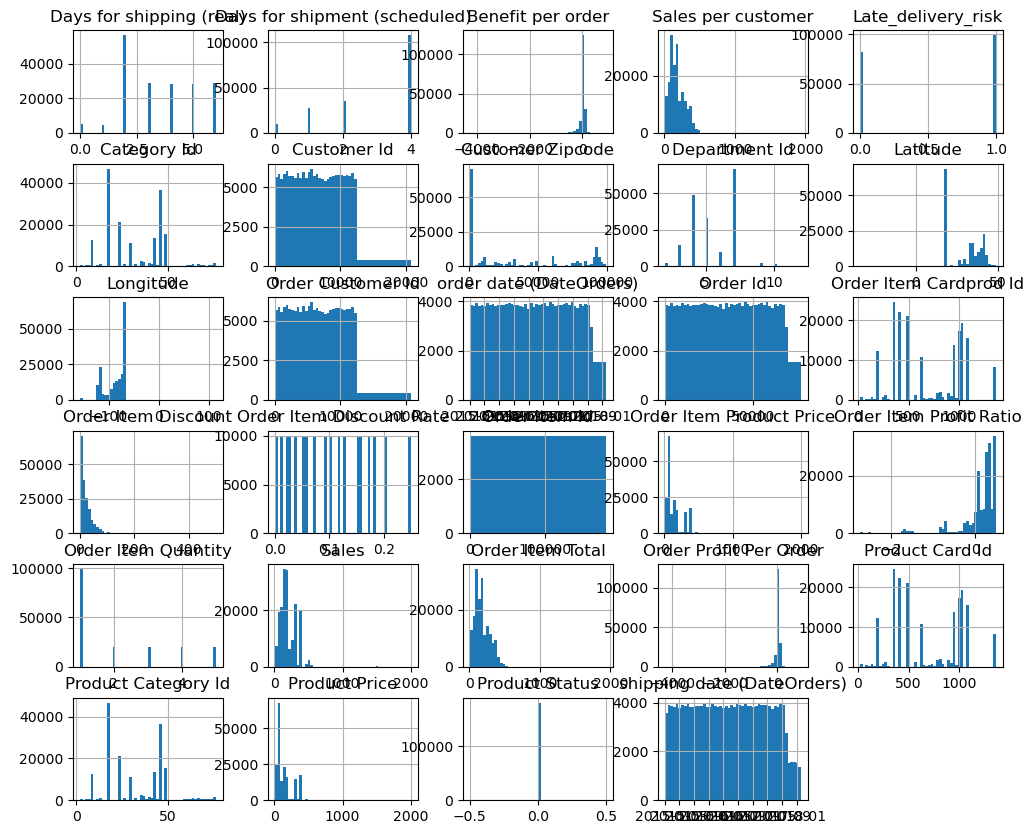

In [7]:
plt.figure(figsize=(12, 10))
df.hist(figsize=(12, 10), bins=50)
plt.show()

### Boxplots

Boxplots help detect outliers and understand feature ranges.

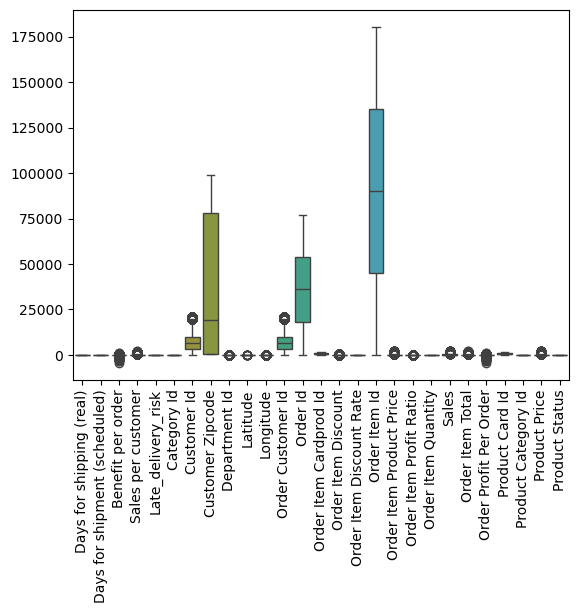

In [18]:
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.show()

### KDE Plots

Kernel Density Estimation (KDE) plots show probability distributions of numerical features. When there is a low number of unique values, a bar plot is chosen instead of a KDE one.

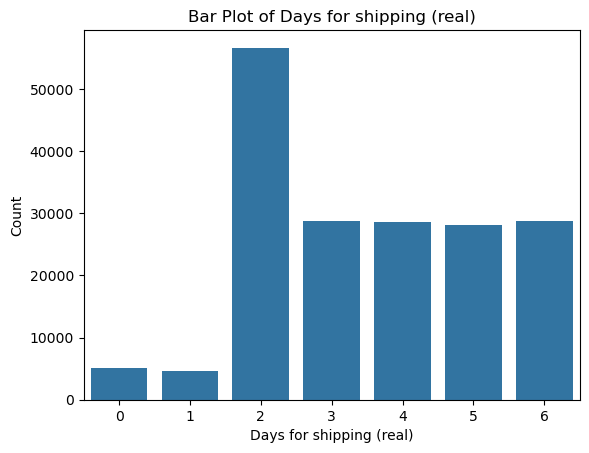

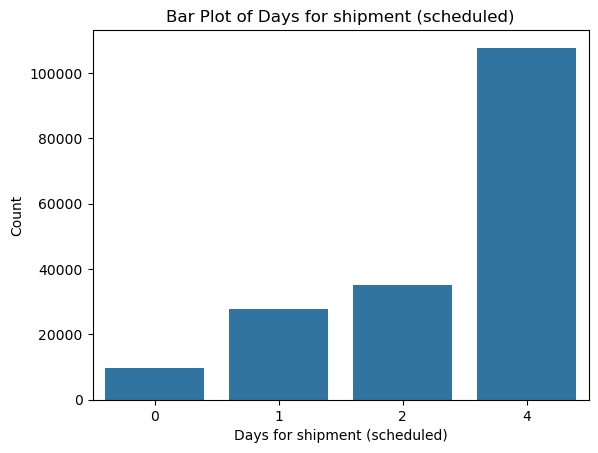

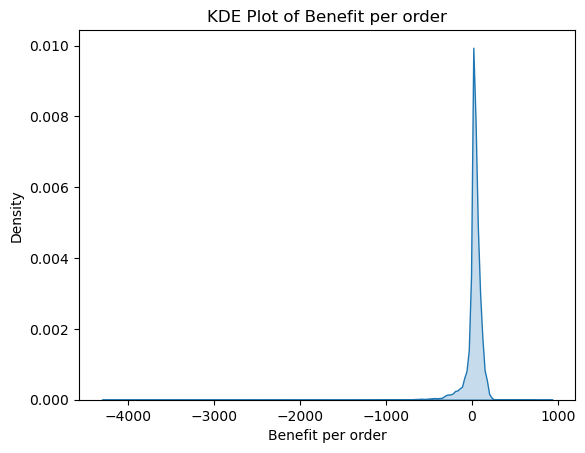

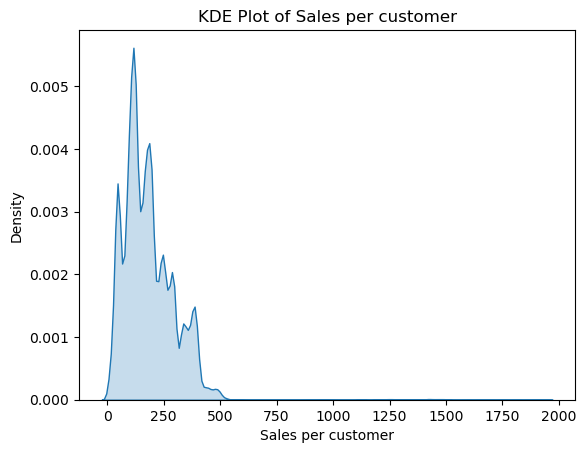

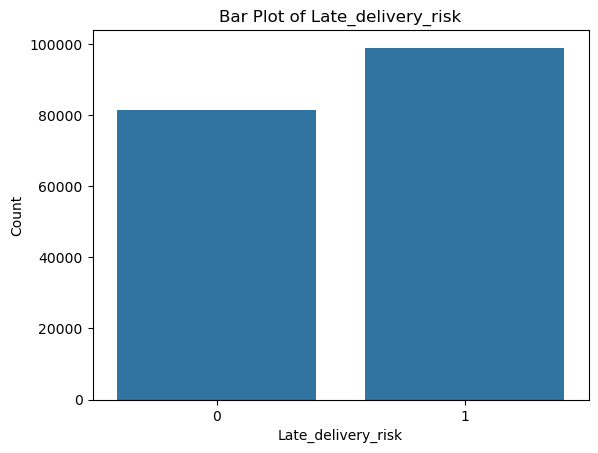

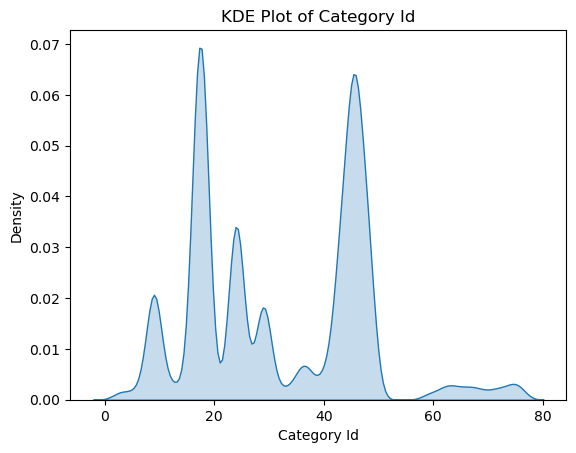

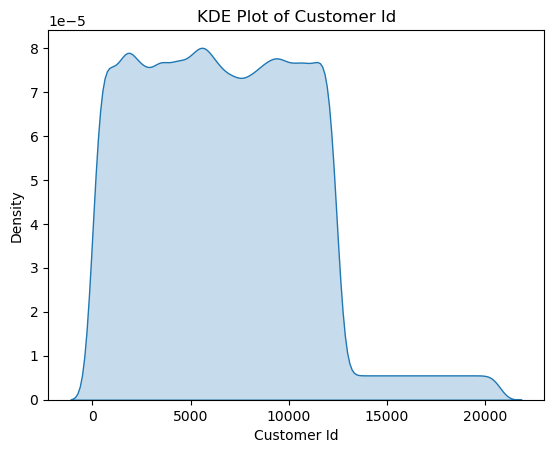

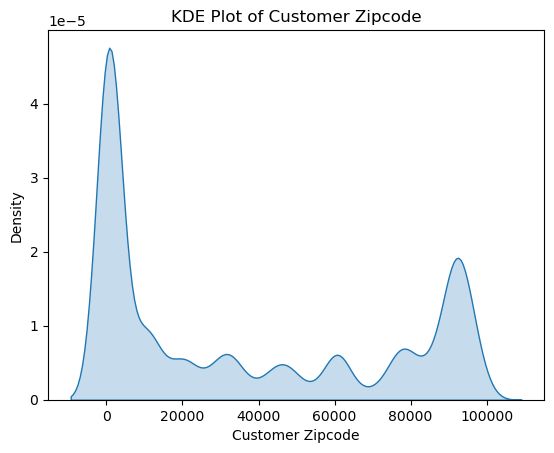

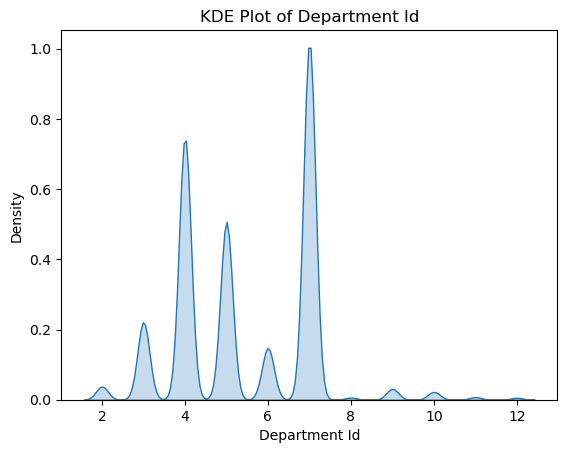

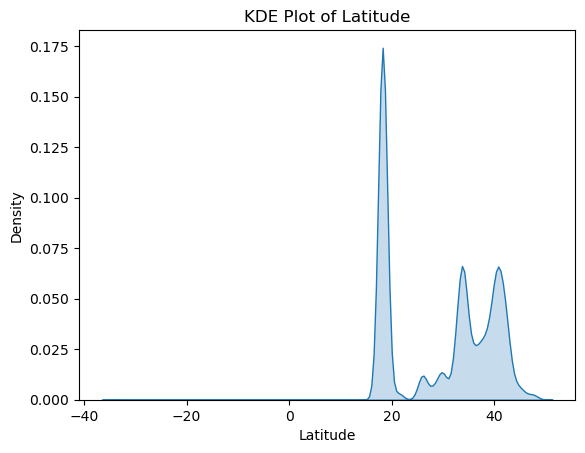

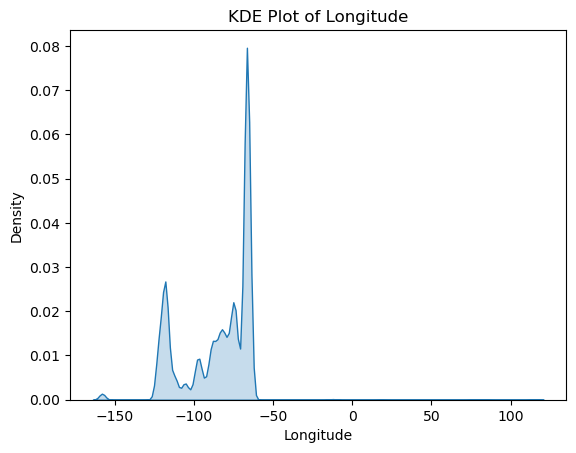

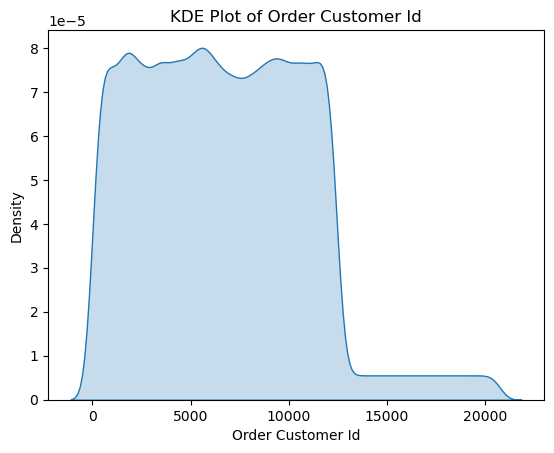

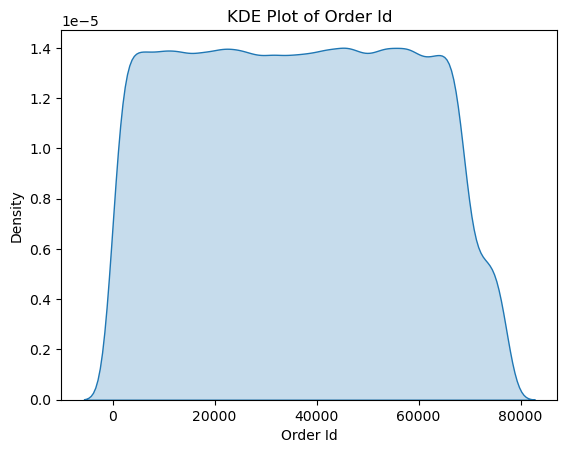

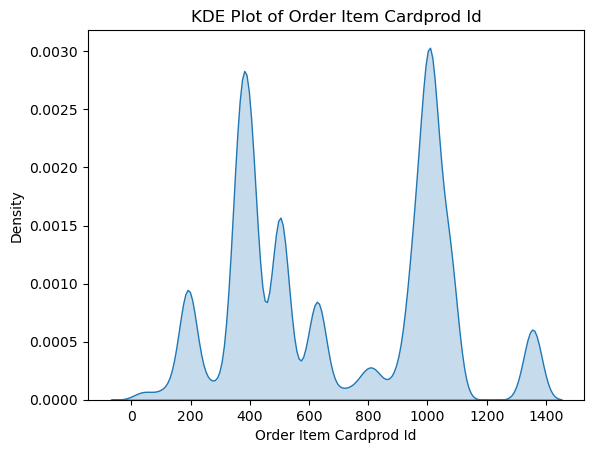

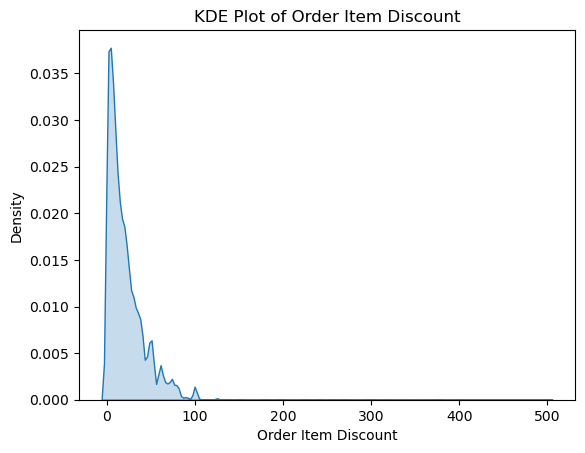

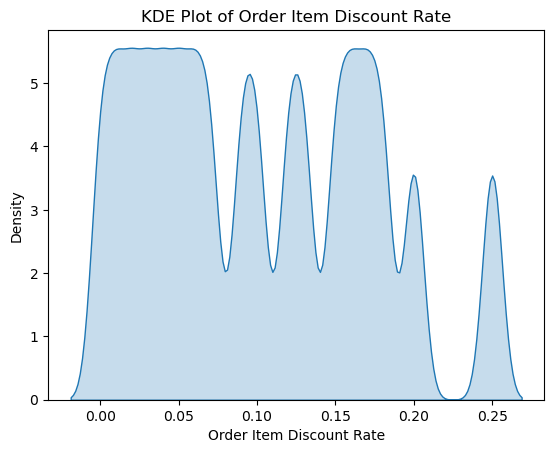

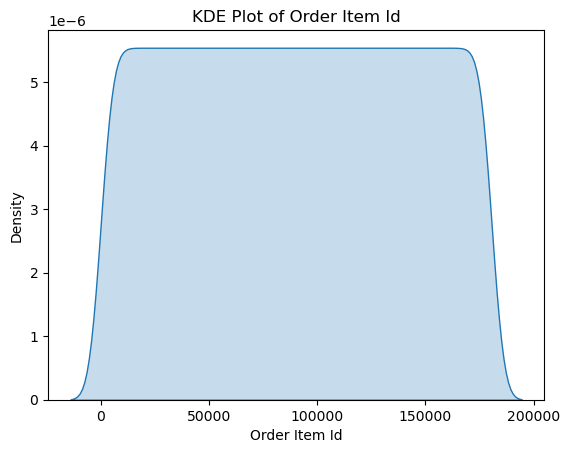

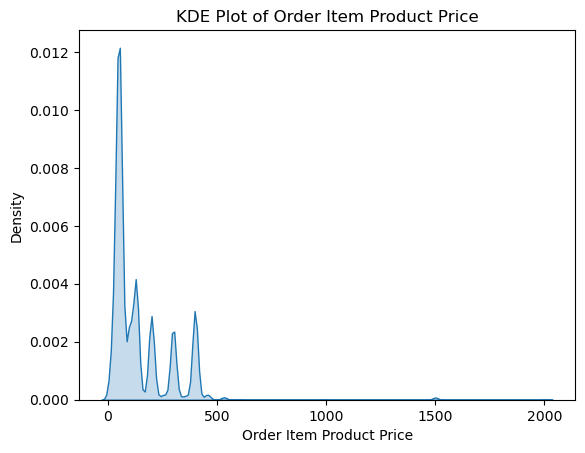

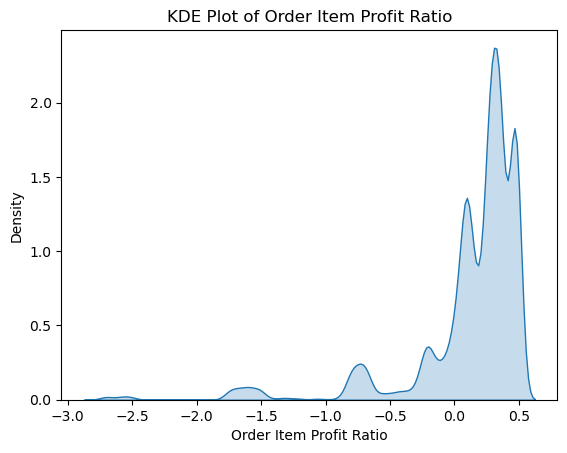

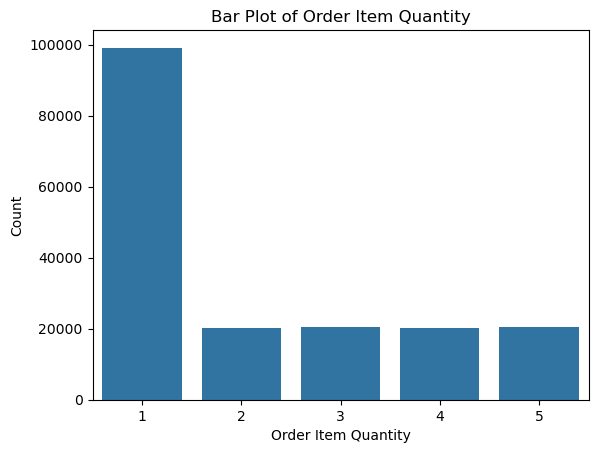

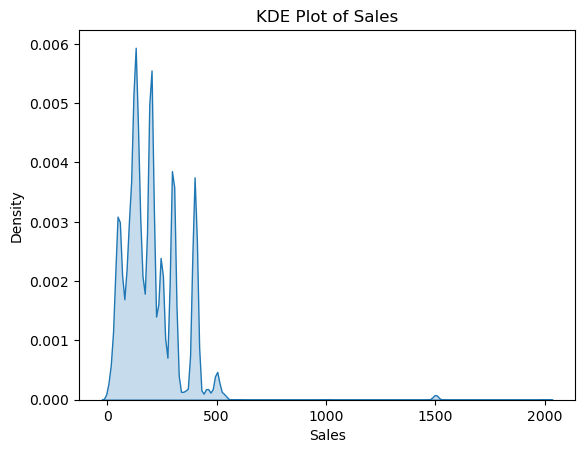

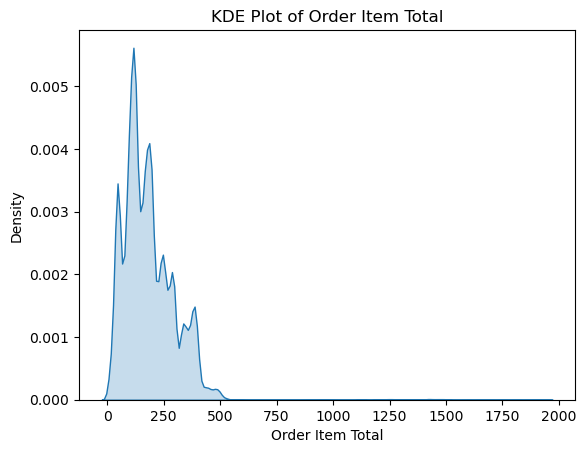

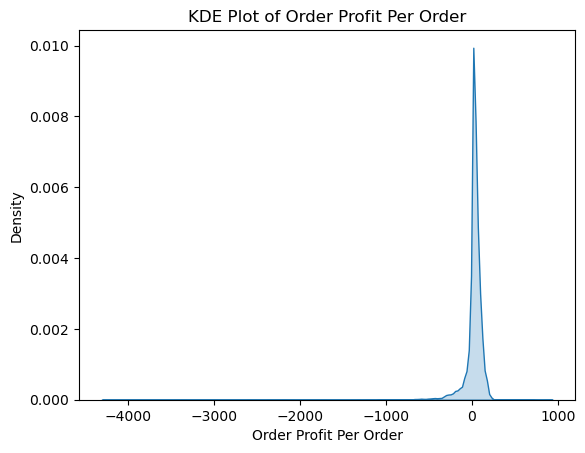

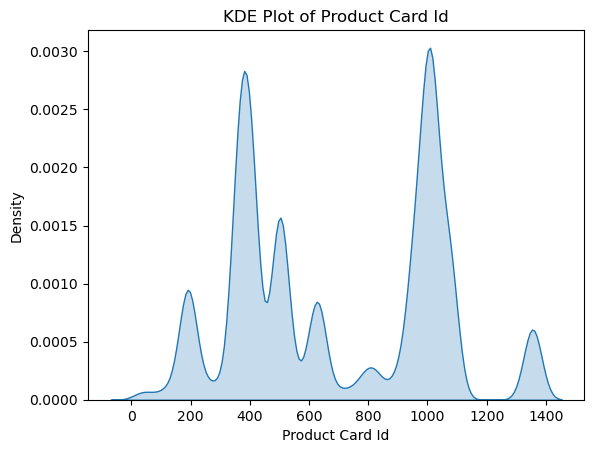

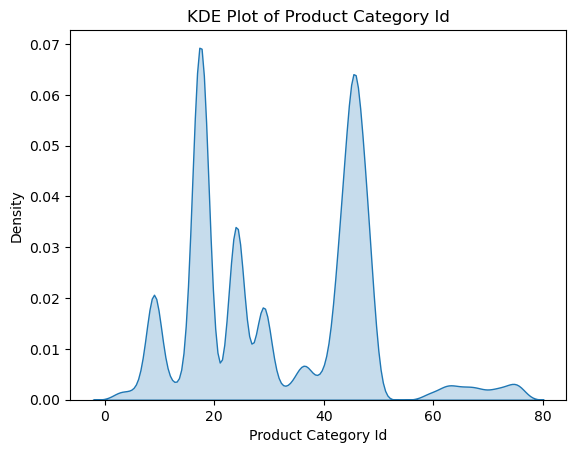

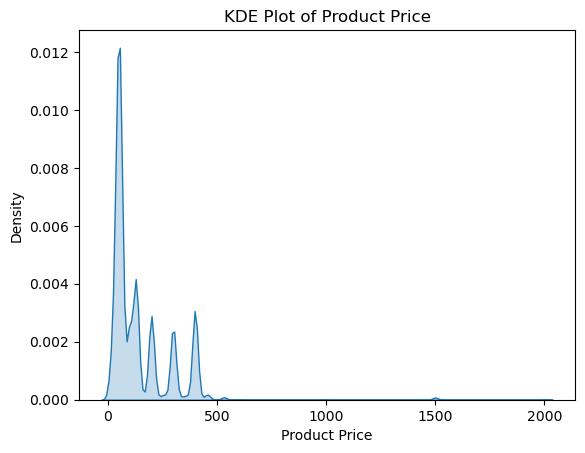

Skipping Product Status


In [13]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    unique_values = df[column].nunique()

    if unique_values > 10:  
        sns.kdeplot(df[column], fill=True)
        plt.title(f"KDE Plot of {column}")
    elif unique_values > 1: 
        sns.barplot(x=df[column].value_counts().index, 
                    y=df[column].value_counts().values)
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.title(f"Bar Plot of {column}")
    else:
        print(f"Skipping {column}")
    
    plt.show()

## Baseline Model - Order Profit Distribution

To establish a baseline, we first analyze the distribution of the target variable (`Order Profit Per Order`).  
Understanding this distribution helps identify potential skewness, outliers, and necessary transformations.  
Additionally, we compute a simple baseline model by predicting the **mean order profit** and measuring its performance using **Mean Absolute Error (MAE)**.

Distribution of Order Profit Per Order:


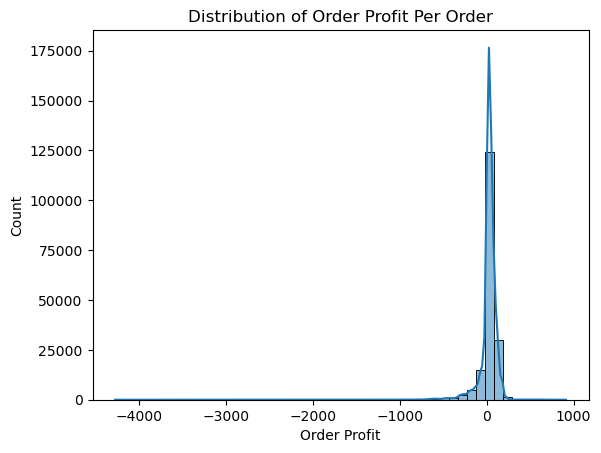

In [15]:
print("Distribution of Order Profit Per Order:")
sns.histplot(df['Order Profit Per Order'], bins=50, kde=True)
plt.title("Distribution of Order Profit Per Order")
plt.xlabel("Order Profit")
plt.ylabel("Count")
plt.show()

In [11]:
# Baseline Model - Predicting with Mean Order Profit
baseline_prediction = df['Order Profit Per Order'].mean()

# Compute Mean Absolute Error (MAE) as a baseline metric
baseline_mae = np.mean(np.abs(df['Order Profit Per Order'] - baseline_prediction))

print(f"Baseline Prediction (Mean Order Profit): {baseline_prediction:.2f}")
print(f"Baseline MAE: {baseline_mae:.2f}")

Baseline Prediction (Mean Order Profit): 21.97
Baseline MAE: 56.09


## Multivariate Analysis
---
### Feature Correlation

Understanding relationships between variables using a correlation heatmap.

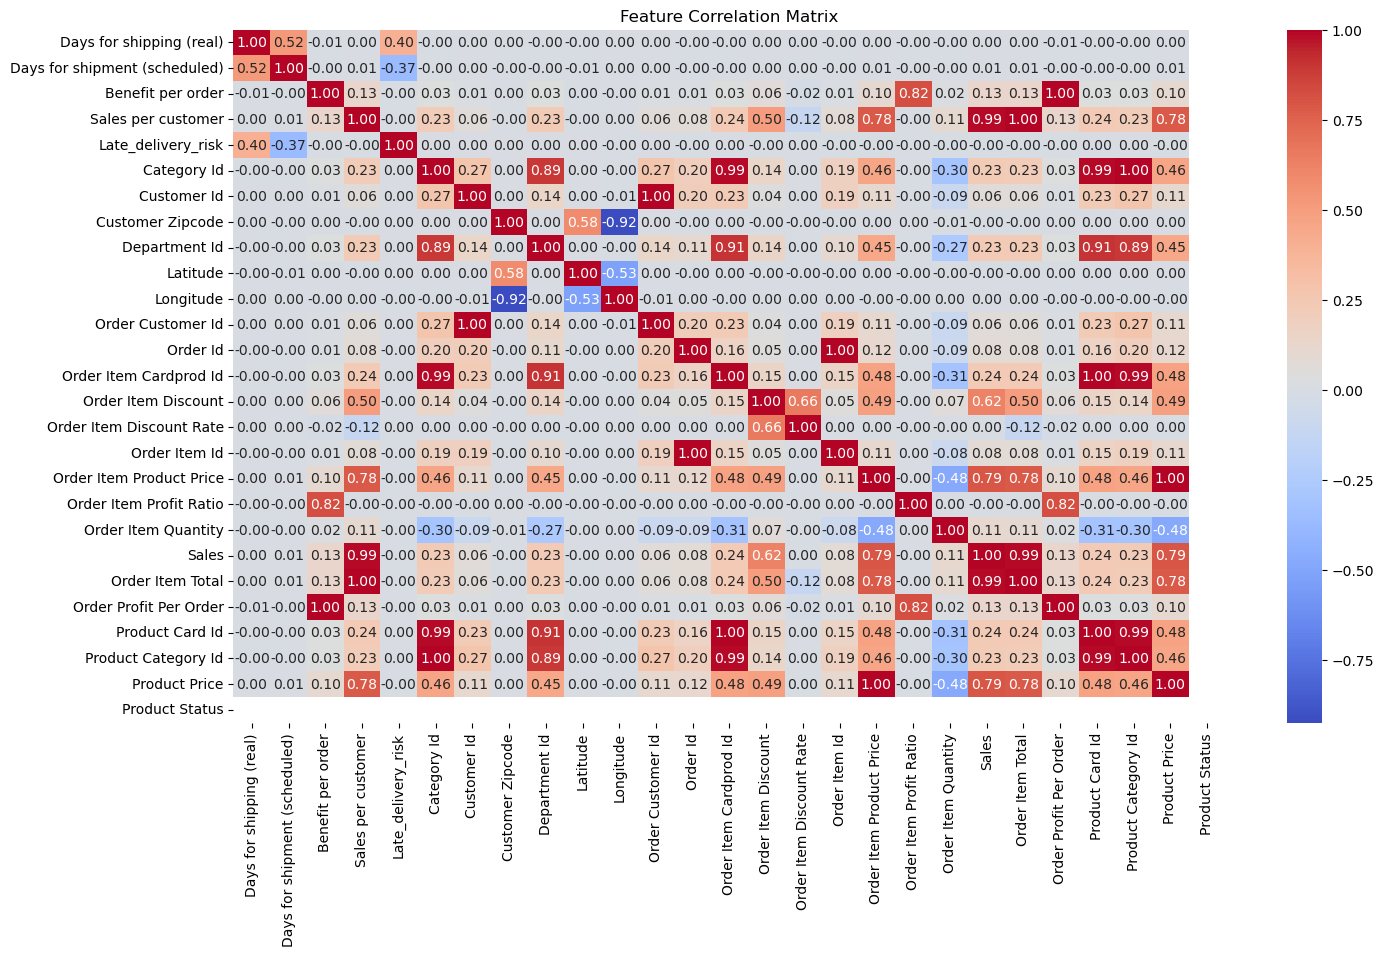

In [22]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(16, 9))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Pairplot

Pairplots help us visualize relationships and potential patterns between key numerical variables. The features `Sales`, `Order Item Total`, `Order Profit Per Order` and `Order Item Quantity` are chosen for their relevance in this research

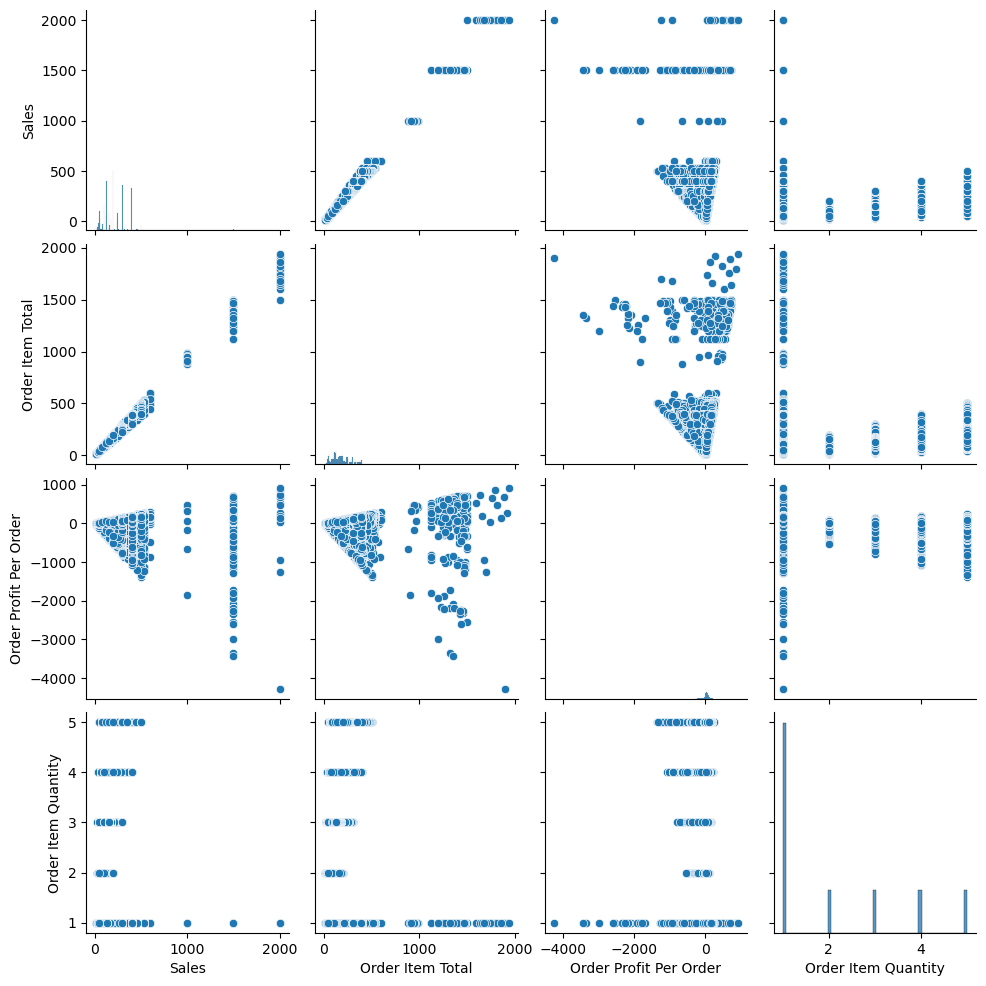

In [24]:
features = ['Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Item Quantity']
sns.pairplot(df[features])
plt.show()

### Data Cleaning - Handling Missing Values

Filling missing values using the median ensures the dataset remains balanced and avoids bias.

In [26]:
df[df.select_dtypes(include=['float64', 'int64']).columns] = \
    df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.fillna(x.median()))

### Data Normalization - Standardization

Standardization ensures all features are on a similar scale, improving model performance.

In [27]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(df[df.select_dtypes(include=['float64', 'int64']).columns])

### Categorical Variable Analysis

In addition to numerical variables, categorical variables can provide valuable insights. We analyze how different categories impact the target variable (`Order Profit Per Order`). This is done by grouping and averaging them. 

In [28]:
category_features = ['Shipping Mode', 'Customer Segment']
for feature in category_features:
    print(f"Mean Order Profit grouped by {feature}:\n", df.groupby(feature)['Order Profit Per Order'].mean())
    print("\n")

Mean Order Profit grouped by Shipping Mode:
 Shipping Mode
First Class       23.122238
Same Day          20.850203
Second Class      21.305889
Standard Class    21.999169
Name: Order Profit Per Order, dtype: float64


Mean Order Profit grouped by Customer Segment:
 Customer Segment
Consumer       22.175390
Corporate      21.949204
Home Office    21.437359
Name: Order Profit Per Order, dtype: float64


